In [1]:
import numpy as np
import matplotlib.pyplot as plt
from radTrans import*
plt.rcParams.update({'font.size': 6})

# This code outlines how to load emissivity and opacity tables (here, generated with Prismspect), and produce interpolation models that can output emissivity and opcity for a given density and temperature.

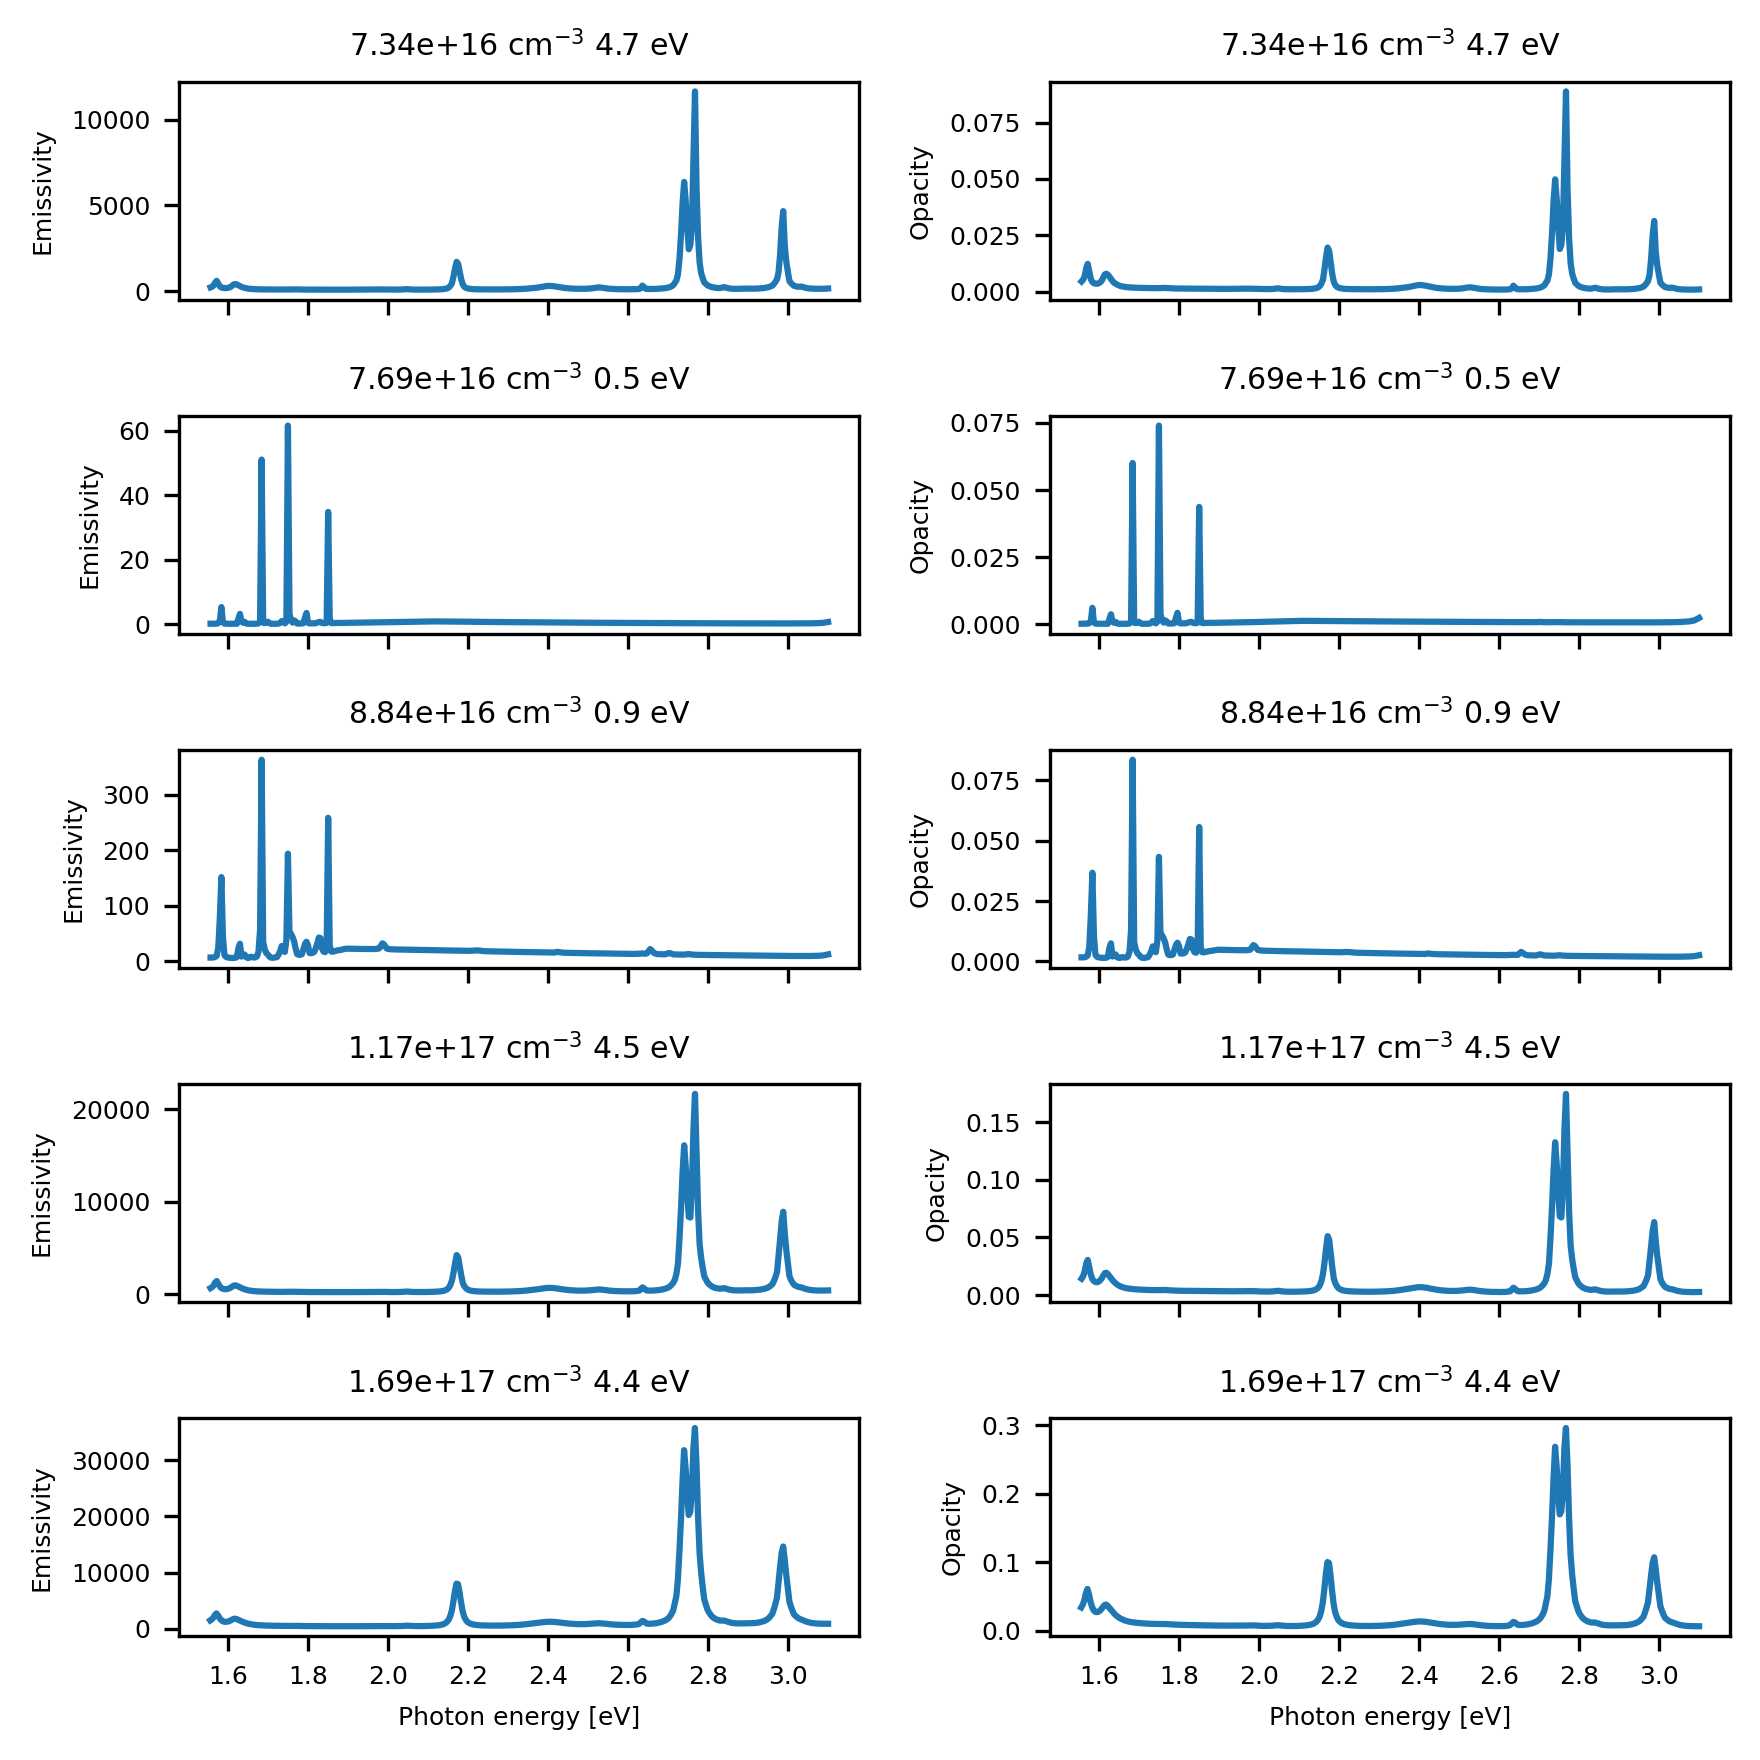

In [2]:
# Load the ni and T values used for the PrismSPECT Simulation
data = np.loadtxt("./Data/valuesV3.csv",
                 delimiter=",")
n_list = data[:,0] # cm^-3
T_list = data[:,1] # eV
# print(n_list)
# print(T_list)

# Plot some example spectra
inDir = './Data/AlVisibleV3/results/'

n_idx = np.random.randint(0,99, size=5) # randomly generate some indixes
T_idx = np.random.randint(0,50, size=5)

n_idx.sort() # sort so ni is increaisng
# T_idx.sort()

ni = n_list[n_idx]; T = T_list[T_idx] # values corresponding to indices

fig,axs = plt.subplots(ni.shape[0],2,figsize=(6,6),dpi=300,sharex=True)

for ii in range(ni.shape[0]):
    E,emi,opa = getEmiOpa(ni[ii],T[ii],n_list,T_list,inDir)
    axs[ii,0].plot(E,emi)
    axs[ii,0].set_title(str(ni[ii]) + ' cm$^{-3}$ ' + str(T[ii]) + ' eV')
    axs[ii,0].set_ylabel('Emissivity')
    
    axs[ii,1].plot(E,opa)
    axs[ii,1].set_title(str(ni[ii]) + ' cm$^{-3}$ ' + str(T[ii]) + ' eV')
    axs[ii,1].set_ylabel('Opacity')

axs[ni.shape[0]-1,0].set_xlabel("Photon energy [eV]")
axs[ni.shape[0]-1,1].set_xlabel("Photon energy [eV]")
fig.tight_layout(pad=2.0)
plt.show()

In [ ]:
# save as csv files ready to import
# x = [ni,T] 10,000 x 2 array
# y = 10,000 x 300 vector
x = np.zeros((n_list.shape[0]*T_list.shape[0],2))
y_emi = np.zeros((n_list.shape[0]*T_list.shape[0],400))
y_opa = np.zeros((n_list.shape[0]*T_list.shape[0],400))
ridx = 0
for ii in range(n_list.shape[0]):
    for jj in range(T_list.shape[0]):
        x[ridx,0] = n_list[ii]
        x[ridx,1] = T_list[jj]
        E,y_emi[ridx,:],y_opa[ridx,:] = getEmiOpa(n_list[ii],T_list[jj],n_list,T_list,inDir)
        ridx+=1
# np.savetxt('x.csv',x)
# np.savetxt('y_emi.csv',y_emi)
# np.savetxt('y_opa.csv',y_opa)

np.save('./Data/x.npy',x)
np.save('./Data/E.npy',E) # 1 x 400 vector
np.save('./Data/y_emi.npy',y_emi)
np.save('./Data/y_opa.npy',y_opa)


In [5]:
(np.log10(n_list.max()) - np.log10(n_list.min()))

3.0

In [6]:
# Split dataset into test, train and validation

E = np.load('./Data/E.npy')
x = np.load('./Data/x.npy')
y = np.load('./Data/y_emi.npy')

def scale(x): # Scale the data
    x[:,0] = (np.log10(x[:,0]) - np.log10(n_list.min())) / (np.log10(n_list.max()) - np.log10(n_list.min())) # scale denisty
    x[:,1] = (x[:,1] - T_list.min()) / (T_list.max()-T_list.min()) # scale temp. 
    return x

x_scale = scale(x) # scaled x

from sklearn.model_selection import train_test_split


x_tv, x_test, y_tv, y_test = train_test_split(x_scale, y, test_size=0.1, random_state=56)
x_train, x_val, y_train, y_val = train_test_split(x_tv, y_tv, test_size=0.1, random_state=100)

print('Shape of training set:')
print('x:', x_train.shape)
print('y:',  y_train.shape)
print('Shape of validation set:')
print('x:', x_val.shape)
print('y:',  y_val.shape)
print('Shape of test set:')
print('x: ',  x_test.shape)
print('y: ',  y_test.shape)



Shape of training set:
x: (18225, 2)
y: (18225, 400)
Shape of validation set:
x: (2025, 2)
y: (2025, 400)
Shape of test set:
x:  (2250, 2)
y:  (2250, 400)


In [7]:
T_list.max()

15.0

k =  2
Coeff. of Determination (R2) =99.83918163582192%
k =  3
Coeff. of Determination (R2) =99.92238718118142%
k =  4
Coeff. of Determination (R2) =99.93674605525933%
k =  5
Coeff. of Determination (R2) =99.93521060916547%
k =  6
Coeff. of Determination (R2) =99.94426586094889%
k =  7
Coeff. of Determination (R2) =99.94396213644177%
k =  8
Coeff. of Determination (R2) =99.93856627072705%


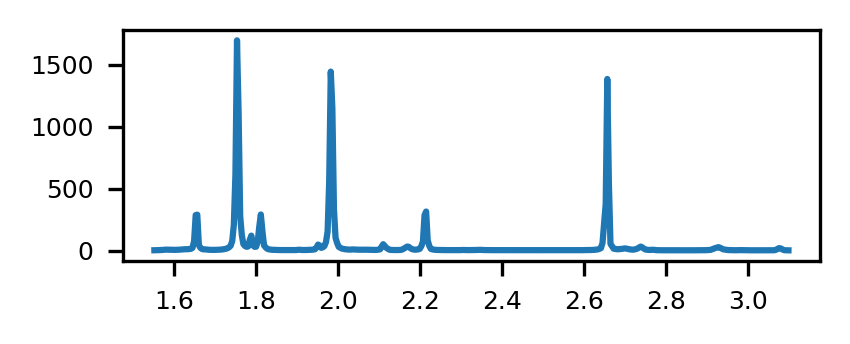

In [6]:
# try a k-nearest neighnor regression model
from sklearn.neighbors import KNeighborsRegressor

for ii in range(2,9):
    print('k = ', ii)
    knr = KNeighborsRegressor(n_neighbors=ii,weights='distance')
    knr.fit(x_train,y_train)
    score = knr.score(x_val,y_val)
    print('Coeff. of Determination (R2) =' + str(100*score) + '%')
    if ii == 2:
        knrbest = knr;
        scorebest = score;
    else:
        if score > scorebest:
            knrbest = knr;
    
            

def scale_ni(x):
    return (np.log10(x)-np.log10(n_list.min())) / (np.log10(n_list.max()) - np.log10(n_list.min()))

def scale_T(x):
    return (x-T_list.min()) / (T_list.max()-T_list.min())

def descale_ni(x):
    return np.around(10**((np.log10(n_list.max()) - np.log10(n_list.min())) * x + np.log10(n_list.min())),decimals=3)

def descale_T(x):
    return np.round(x * (T_list.max()-T_list.min()) + T_list.min(),decimals=2)


out = knrbest.predict(np.array([[scale_ni(3.2e16),scale_T(1.5)]]))

fig,axs = plt.subplots(1,1,figsize=(3,1),dpi=300)
axs.plot(E,out[0])

plt.show()

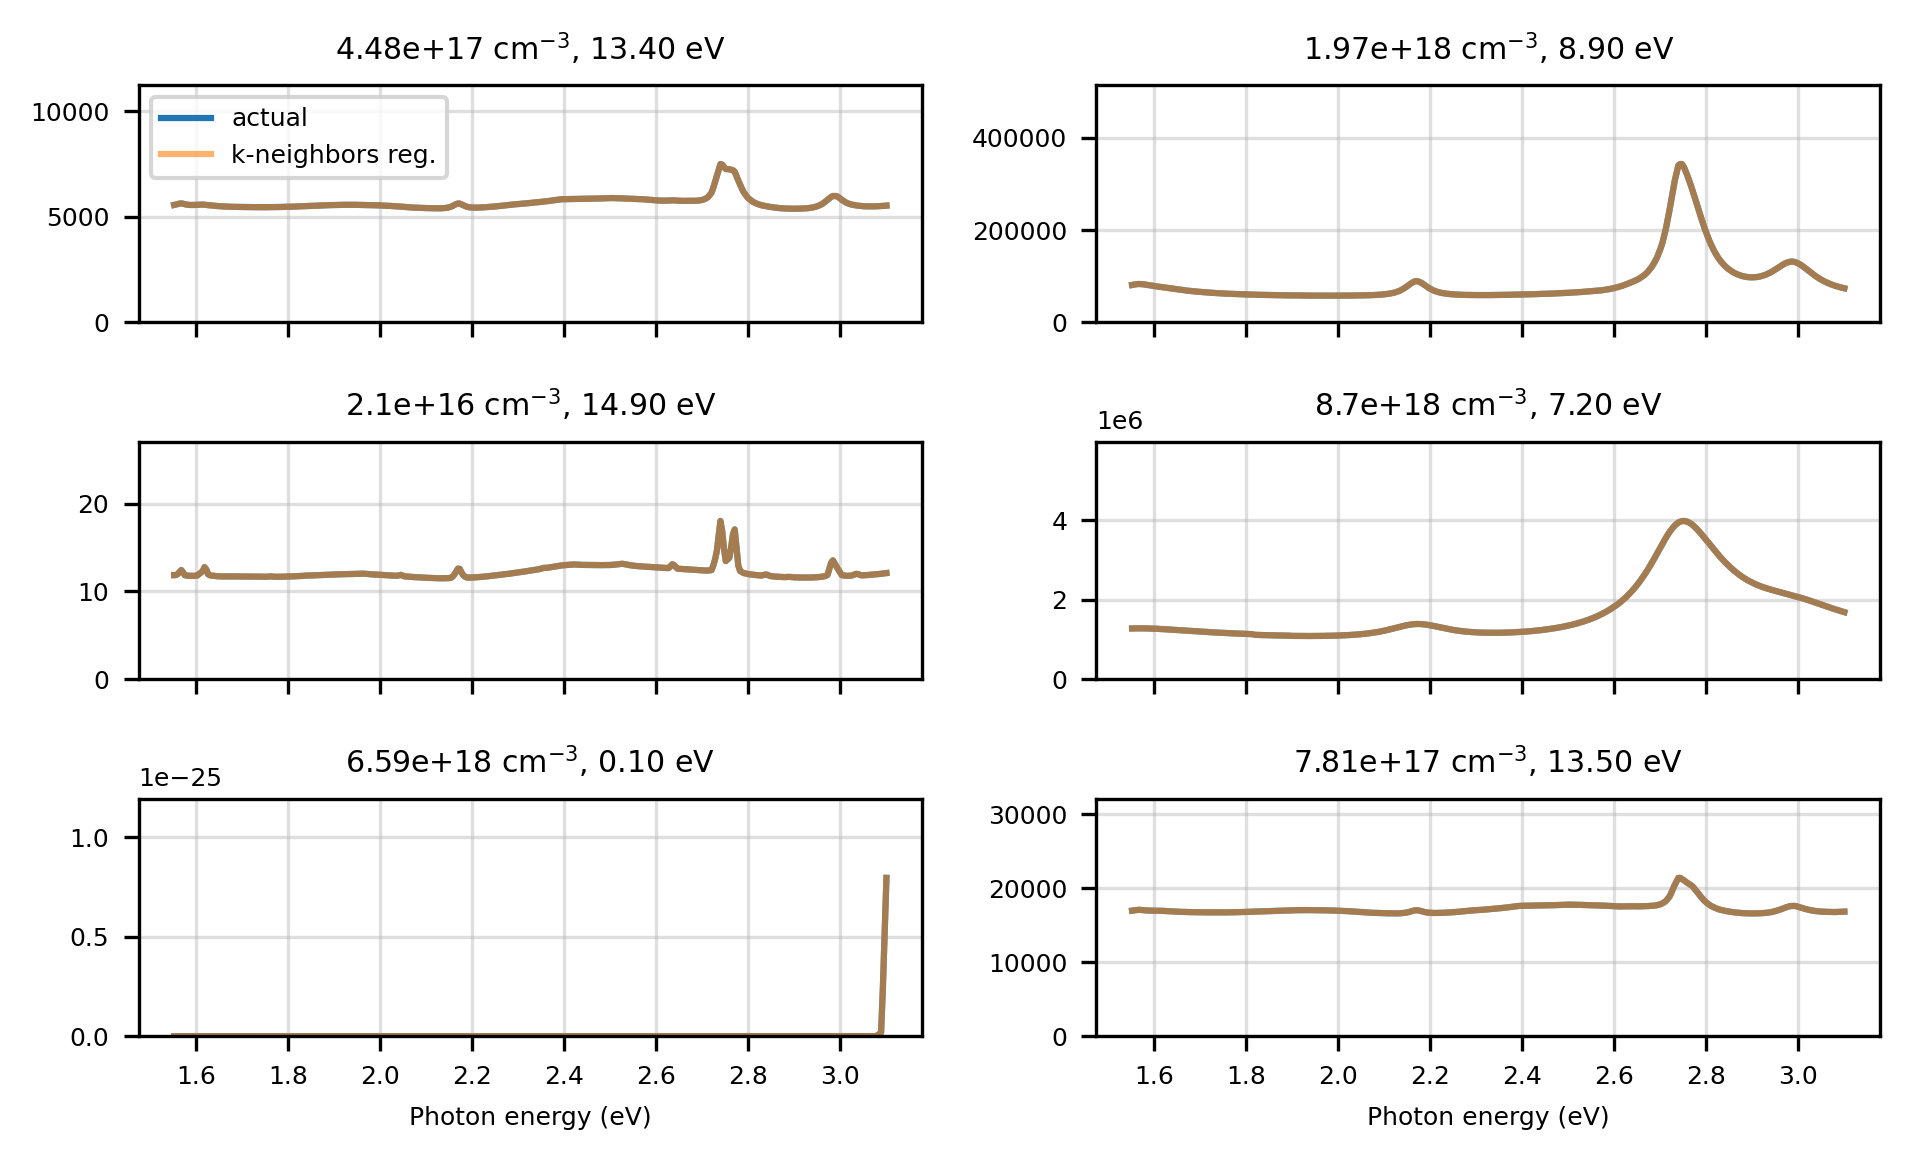

In [7]:
# compare with train set
idx = np.random.randint(0,x_train.shape[0]-1,6) # random indices within (scaled) test set

fig,axs = plt.subplots(3,2,figsize=(6.5,4),dpi=300,sharex=True)
for ii in range(idx.shape[0]):
    emi = y_train[idx[ii],:]
    axs[ii % 3, ii // 3].plot(E,emi,label='actual')
    
    out = knrbest.predict(np.array([[x_train[idx[ii],0],x_train[idx[ii],1]]]))
    axs[ii % 3, ii // 3].plot(E,out[0],label='k-neighbors reg.',alpha=0.6)
    
    axs[ii % 3, ii // 3].set_title('%0.3g cm$^{-3}$, %0.2f eV' % (descale_ni(x_train[idx[ii],0]),descale_T(x_train[idx[ii],1])))
    axs[ii % 3, ii // 3].set_ylim([0,1.5*out[0].max()])
    axs[ii % 3, ii // 3].grid(alpha=0.4)
axs[-1,0].set_xlabel('Photon energy (eV)')
axs[-1,1].set_xlabel('Photon energy (eV)')
fig.tight_layout(pad=2.0)
axs[0,0].legend()
plt.show()    

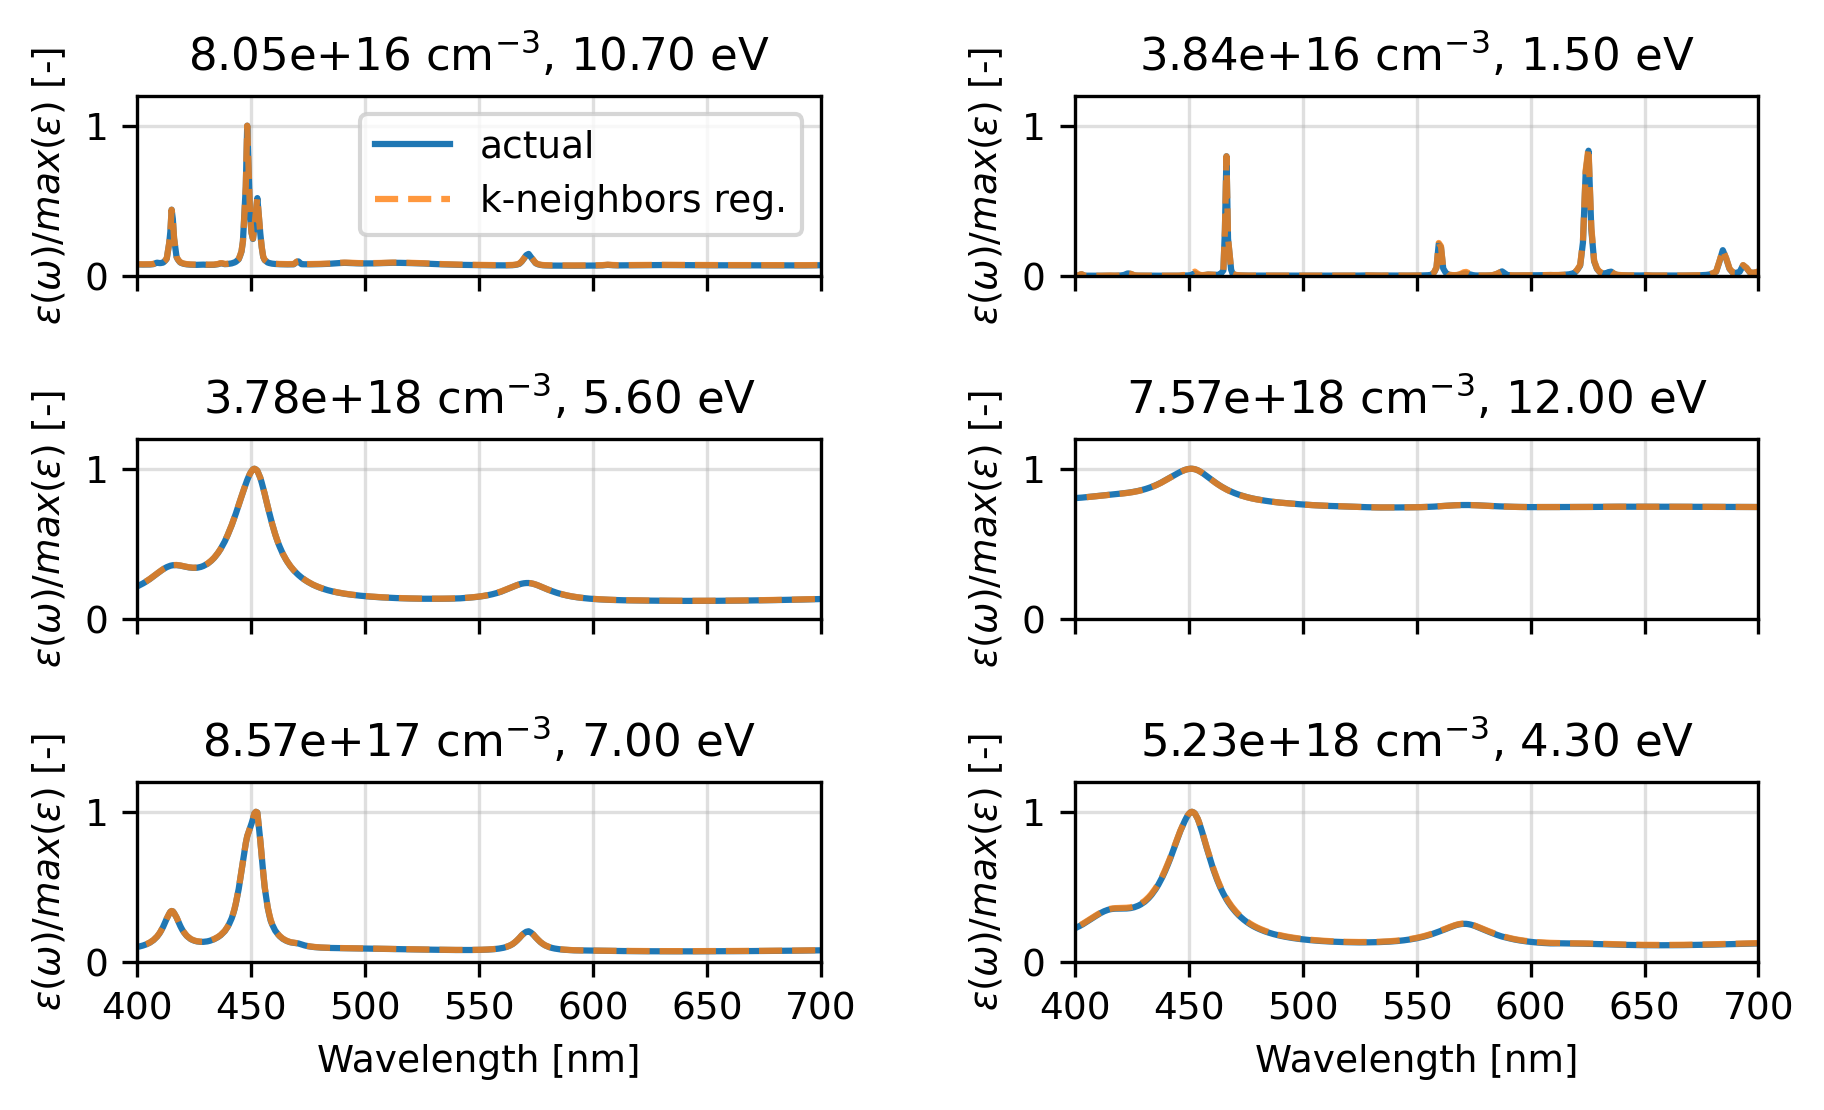

In [30]:
# compare with test set
idx = np.random.randint(0,x_test.shape[0]-1,6) # random indices within (scaled) test set

plt.rcParams.update({'font.size':9})
fig,axs = plt.subplots(3,2,figsize=(6.5,4),dpi=300,sharex=True)
for ii in range(idx.shape[0]):
    emi = y_test[idx[ii],:]
    axs[ii % 3, ii // 3].plot(1239.8/E,emi/emi.max(),label='actual')
    
    out = knrbest.predict(np.array([[x_test[idx[ii],0],x_test[idx[ii],1]]]))
    axs[ii % 3, ii // 3].plot(1239.8/E,out[0]/np.max(out[0]),linestyle='--',label='k-neighbors reg.',alpha=0.8)
    
    axs[ii % 3, ii // 3].set_title('%0.3g cm$^{-3}$, %0.2f eV' % (descale_ni(x_test[idx[ii],0]),descale_T(x_test[idx[ii],1])))
    axs[ii % 3, ii // 3].set_ylim([0,1.2])
    axs[ii % 3, ii // 3].grid(alpha=0.4)
    axs[ii % 3, ii // 3].set_xlim([400,700])
    axs[ii % 3, ii // 3].set_ylabel('$\epsilon(\omega) / max(\epsilon)$ [-]')
axs[-1,0].set_xlabel('Wavelength [nm]')
axs[-1,1].set_xlabel('Wavelength [nm]')
fig.tight_layout(pad=2.0)
axs[0,0].legend()
plt.show()   

saveDir = '/Users/rishabhdatta/Dropbox (MIT)/PUFFIN/Writing/Figures/ML_paper/'
fig.savefig(saveDir+'KNN_emissivity.png',bbox_inches='tight',dpi=600)
    

In [23]:
# Hyperparamter optimization

# KNN
import optuna
from sklearn.model_selection import cross_val_score
KNN = KNeighborsRegressor(n_neighbors=10)

def objective(trial):
        x = x_train
        y = y_train
        num_neighbors = trial.suggest_int('num_neighbors', 2, 32, log=True)
        regressor =  KNeighborsRegressor(n_neighbors=num_neighbors)
        score = cross_val_score(regressor, x, y, scoring='r2', n_jobs=-1, cv=3)
        score = score.mean()
        return score

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2023-08-17 08:58:22,969] A new study created in memory with name: no-name-939819bd-de85-4ea3-99b6-1a2f6c8c1b41
[I 2023-08-17 08:58:24,403] Trial 0 finished with value: 0.9911512939703905 and parameters: {'num_neighbors': 32}. Best is trial 0 with value: 0.9911512939703905.
[I 2023-08-17 08:58:24,828] Trial 1 finished with value: 0.9982416840727191 and parameters: {'num_neighbors': 3}. Best is trial 1 with value: 0.9982416840727191.
[I 2023-08-17 08:58:25,092] Trial 2 finished with value: 0.9982416840727191 and parameters: {'num_neighbors': 3}. Best is trial 1 with value: 0.9982416840727191.
[I 2023-08-17 08:58:25,524] Trial 3 finished with value: 0.9982416840727191 and parameters: {'num_neighbors': 3}. Best is trial 1 with value: 0.9982416840727191.
[I 2023-08-17 08:58:26,096] Trial 4 finished with value: 0.994182508802207 and parameters: {'num_neighbors': 22}. Best is trial 1 with value: 0.9982416840727191.
[I 2023-08-17 08:58:26,339] Trial 5 finished with value: 0.9982416840727191

KeyboardInterrupt: 

In [ ]:
# new knr for emissivity
knr_emi = KNeighborsRegressor(n_neighbors=4,weights='distance')
knr_emi.fit(x_scale,y)

# new knr for opacity

y_new = np.load('./Data/y_opa.npy')
knr_opa = KNeighborsRegressor(n_neighbors=4,weights='distance')
knr_opa.fit(x_scale,y_new)

def getEmi(ni,Te):
    ni = scale_ni(ni)
    Te = scale_T(Te)
    emi = knr_emi.predict(np.array([[ni,Te]])) # W/cm^3/sr/eV
    return emi[0]

def getOpa(ni,Te):
    ni = scale_ni(ni)
    Te = scale_T(Te)
    opa = knr_opa.predict(np.array([[ni,Te]])) # cm^-1
    return opa[0]

fig,axs = plt.subplots(2,1,figsize=(5,3),dpi=150,sharex=True)
ni = n_list[150]
Te = T_list[25]
emi = getEmi(ni,Te)
opa = getOpa(ni,Te)
axs[0].plot(E,emi)
axs[0].set_ylabel('Emissivity [W cm$^-3$ sr$^{-1}$ eV$^{-1}$]')
axs[0].set_title('%0.3g cm$^{-3}$, %0.2f eV' % (ni,Te))

axs[1].plot(E,opa)
axs[1].set_ylabel('Opacity [cm$^{-1}$]')
axs[1].set_xlabel('[eV]')
# axs[1].set_xlim([2.2,2.8])
plt.show()


In [31]:
pickle.dump(knr_opa, open('./models/knr_opa.sav', 'wb')) # Save the best model
pickle.dump(knr_emi, open('./models/knr_emi.sav', 'wb'))

0.6666666666666666 0.4897959183673469


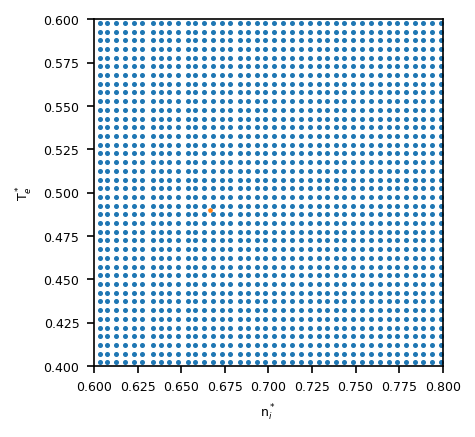

In [31]:
fig,axs = plt.subplots(1,1,figsize=(3,3),dpi=150,sharex=True)
axs.scatter(x_scale[:,0],x_scale[:,1],s=2,marker='o')
print(scale_ni(1e18),scale_T(12.5))
axs.scatter(scale_ni(1e18),scale_T(12.5),s=2,marker='p')
axs.set_xlim([0.6,0.8])
axs.set_ylim([0.4,0.6]) 
axs.set_xlabel('n$_i^*$')
axs.set_ylabel('T$_e^*$')
plt.show()